## Power Spectrum based on OLR

### Import package

In [1]:
import numpy as np;
import netCDF4 as nc;

from scipy.ndimage import convolve1d;
from matplotlib import pyplot as plt;

### Load file

In [2]:
fpath = "/work/DATA/Satellite/OLR/olr_anomaly.nc";

with nc.Dataset( fpath, "r" ) as ds:
    dims = {
        key: ds[key][:]
        for key in ds.dimensions.keys()
    };
    
    lat_lim = np.where( ( dims["lat"] >= -5.0 ) & ( dims["lat"] <= 5.0 ) )[0];
    dims["lat"]  = dims["lat"][lat_lim];
    dims["time"] = dims["time"][:1000];
    
    olr = ds["olr"][:1000, lat_lim, :];

### Processing data

#### Form symmetric data

In [3]:
olr -= olr.mean( axis=(0, 2), keepdims=True )

sym = ( olr + np.flip( olr, axis=1 ) ) / 2;

### Space-Time Filtering

#### Project symmetric data to frequency space

In [7]:
def fft2( data ):
    
    data_fft = np.fft.fft( data, axis=0 ) ;
    data_fft = np.fft.ifft( data_fft, axis=-1 ) * data.shape[-1];
    
    return data_fft.sum( axis=1 );

sym_fft = fft2( sym ); # compute 2-dimensional FFT on symmetric data

#### Setup filter for specific waves

In [18]:
# Setup axis 
wn = np.fft.fftfreq( dims["lon"].size, d=1/dims["lon"].size );
fr = np.fft.fftfreq( dims["time"].size, d=1 );

wnm, frm = np.meshgrid( wn, fr ); # meshgrid of wavenumber and frequency

kel_curve = lambda wn, ed: ( 86400.0 / ( 2*np.pi*2.5e6 ) ) * np.sqrt( 9.81 * ed ) * wn; # dispersion relation of Kelvin wave

# Masking data (This is only for Kelvin waves)
mask = np.where( 
                (( wnm >= 1 ) & ( wnm <= 15 ) & # wavenumber range: 1~15
                ( frm >= 1/20 ) & ( frm <= 0.5 ) & # frequency range: 1/20~1/2
                ( frm >= kel_curve(wnm, 10) ) & ( frm <= kel_curve(wnm, 100) )) |
                (( wnm <= -1 ) & ( wnm >= -15 ) &
                ( frm <= -1/20 ) & ( frm >= -0.5 ) &
                ( frm >= kel_curve(wnm, 10) ) & ( frm <= kel_curve(wnm, 100) )),
                1.0, 0.0
                );

# masking symmetric data
sym_fft_masked = sym_fft * mask;

# inverse data back to physical domain
def ifft2( data ):
    
    data_ifft = np.fft.ifft( data, axis=0 ) ;
    data_ifft = np.fft.fft( data_ifft, axis=-1 ) / data.shape[-1];
    
    return data_ifft.real;

kel_reconstruct = ifft2( sym_fft_masked );

## Plot

(1.0, 100.0)

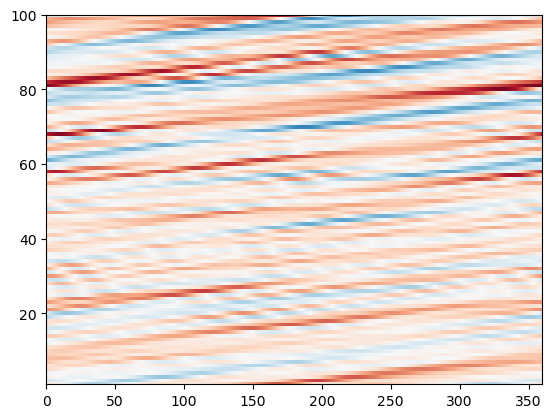

In [22]:
plt.pcolormesh( dims["lon"], np.linspace( 1, 1000, 1000 ), kel_reconstruct, cmap="RdBu" )
plt.ylim( 1, 100 )